In [1]:
from tinyphysics import TinyPhysicsModel, TinyPhysicsSimulator, CONTROL_START_IDX
from controllers import simple, BaseController
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_theme()


In [2]:
def plot_rollout(sim):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(sim.target_lataccel_history, label="Target Lateral Acceleration", alpha=0.5)
    ax.plot(sim.current_lataccel_history, label="Actual Lateral Acceleration", alpha=0.5)
    ax.legend()
    ax.set_xlabel("Step")
    ax.set_ylabel("Lateral Acceleration")
    ax.set_title("Rollout")
    plt.show()

In [3]:
driving_model = TinyPhysicsModel("./models/tinyphysics.onnx", debug=True)

In [4]:
model = TinyPhysicsModel("./models/tinyphysics.onnx", debug=True)
controller = simple.Controller()

In [5]:
from tqdm import tqdm

def execute_test(filename, controller, driving_model, plot=False):
    sim = TinyPhysicsSimulator(driving_model, filename, controller=controller, debug=False)
    cost = sim.rollout()
    if plot:
        plot_rollout(sim)
    return cost
    
def compare_with_baseline(driving_model, filename, baseline_controller, test_controller):
    baseline_cost = execute_test(filename, baseline_controller, driving_model, plot=True)
    cost = execute_test(filename, test_controller, driving_model, plot=True)
    print(baseline_cost, cost)

In [24]:
# Instantiate the env
import os

eval_env = DriverEnv(driving_model, controller, None, False, 0, ["data/00000.csv"])
log_dir = "/notebooks/comma/tmp/"
#log_dir = "/notebooks/comma/controls_challenge/tmp/"
stats_path = os.path.join(log_dir, "TRPO_Steering_vec_normalize.pkl")
#stats_path = os.path.join(log_dir, "model_checkpoints/rl_model_vecnormalize_280719_steps.pkl")
eval_env = make_vec_env(lambda: eval_env, n_envs=1)
eval_env = VecNormalize.load(stats_path, eval_env)
#  do not update them at test time
eval_env.training = False
# reward normalization is not needed at test time
eval_env.norm_reward = False
eval_env = VecFrameStack(eval_env, 10)

# Load the agent
model = TRPO.load(log_dir + "TRPO_Steering", env=eval_env)
#model = TRPO.load(log_dir + "model_checkpoints/rl_model_280719_steps", env=eval_env)

In [31]:
import pandas as pd

temp = pd.read_csv('data/00002.csv', sep=',')
goodController = BaseController2(eval_env, model, 20, temp)
#goodController = BaseController(booster, scaler, temp)

Retrieving cost for data/00000.csv: 73.61142271153338
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.     

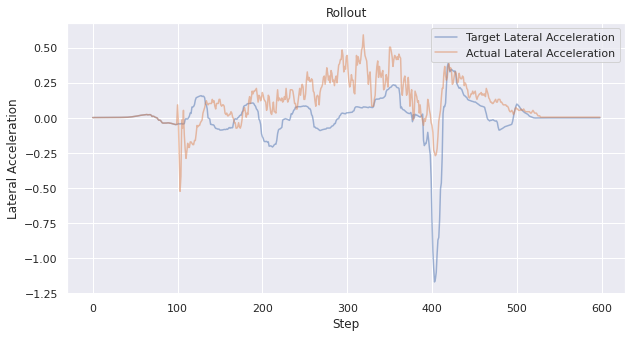

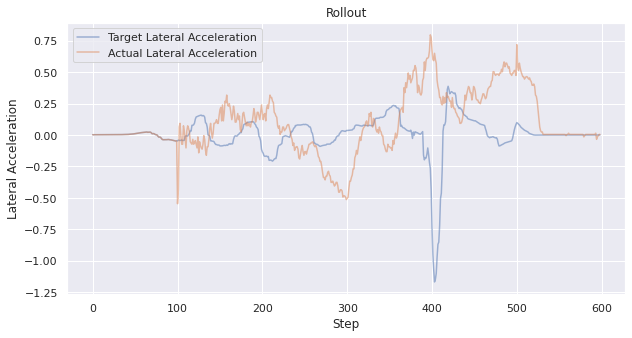

{'lataccel_cost': 4.609353730518906, 'jerk_cost': 25.893590692945118, 'total_cost': 48.94035934553965} {'lataccel_cost': 13.125651672297863, 'jerk_cost': 24.369957215462723, 'total_cost': 89.99821557695203}


In [116]:
compare_with_baseline(driving_model, "./data/00003.csv", controller, goodController)

In [32]:
# TRPO 2 Final without baseline cost
sim = TinyPhysicsSimulator(driving_model, "./data/00002.csv", controller=goodController, debug=False)
sim.rollout()

Cost for data/00000.csv is: {'lataccel_cost': 6.679554461158983, 'jerk_cost': 50.86428747202187, 'total_cost': 84.26205977781679}
-10.650637066283409
Retrieving cost for data/00000.csv: 73.61142271153338


{'lataccel_cost': 5.648043117818136,
 'jerk_cost': 30.165564715887573,
 'total_cost': 58.40578030497825}

In [23]:
import torch
import torch.nn as nn
import numpy as np
import math
import matplotlib.pyplot as plt

class BaseController2:
    
    def __init__(self, env, model, start_idx, data):
        self.env = env
        self.model = model
        self.start_idx = start_idx
        self.data = data
        self.lstm_states = None
        # Episode start signals are used to reset the lstm states
        self.episode_starts = np.ones((1,), dtype=bool)
        self.observation = self.env.reset()
        print(self.observation)
        #for i in range(21, CONTROL_START_IDX):
            #action, self.lstm_states = self.model.predict(self.observation, state=self.lstm_states, episode_start=self.episode_starts, deterministic=True)
        #    action, _ = self.model.predict(self.observation, deterministic=True)
            #self.observation, _, dones, _ = self.env.step([[self.data.iloc[i]['steerCommand']]])
        #    self.observation, _, _, _ = self.env.step([[self.data.iloc[i]['steerCommand']]])
            #self.episode_starts = dones
            #self.observation = self.observation[0]
        print("----")
    
    def update(self, target_lataccel, current_lataccel, state):
        #action, self.lstm_states = self.model.predict(self.observation, state=self.lstm_states, episode_start=self.episode_starts, deterministic=True)
        action, _ = self.model.predict(self.observation, deterministic=True)
        self.observation, _, dones, _ = self.env.step([[action[0][0]]])
        #self.observation, _, dones, _ = self.env.step([[action[0]]])
        #self.observation = self.observation[0]
        #self.episode_starts = dones
        #self.obs, _, _, _, self.info = self.env.step(action)
        return action[0][0]
        #return action[0]

# RL

In [6]:
from tqdm import tqdm
import pandas as pd
dfs = []
to_load = 1
for i in tqdm(range(to_load), total=to_load):
    num_str = str(i)
    while len(num_str) < 5:
        num_str = '0' + num_str
    try:
        temp = pd.read_csv(f'/notebooks/comma/controls_challenge/data/{num_str}.csv', sep=',')
    except:
        print(f'data/{num_str}.csv does not exist')
    dfs.append(temp)
df = pd.concat(dfs)
df['shifted_target'] = df['targetLateralAcceleration'].shift(1).fillna(0)
df.head()

100%|██████████| 1/1 [00:00<00:00, 62.43it/s]


,t,vEgo,aEgo,roll,targetLateralAcceleration,steerCommand,shifted_target
0,0.0,33.770260,-0.017300,0.037470,1.003864,-0.329734,0.000000
1,0.1,33.763533,-0.039069,0.037006,1.049681,-0.335021,1.003864
2,0.2,33.755949,-0.067940,0.036543,1.056292,-0.332706,1.049681
3,0.3,33.758334,-0.022276,0.036579,1.051750,-0.336199,1.056292
4,0.4,33.752904,-0.052032,0.036652,1.059831,-0.352662,1.051750


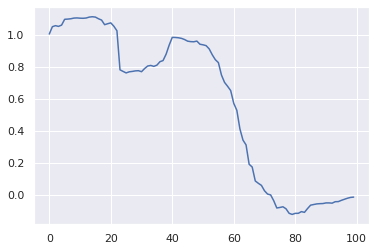

In [20]:
import matplotlib.pyplot as plt

df = pd.read_csv(f'/notebooks/comma/controls_challenge/data/00000.csv', sep=',')
df = df.dropna()
plt.plot(df['targetLateralAcceleration'])
plt.show()

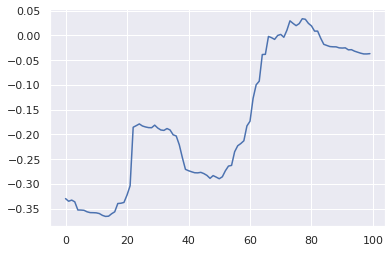

In [21]:
plt.plot(df['steerCommand'])
plt.show()

In [12]:
df[:25]

,t,vEgo,aEgo,roll,targetLateralAcceleration,steerCommand
0,0.0,33.770260,-0.017300,0.037470,1.003864,-0.329734
1,0.1,33.763533,-0.039069,0.037006,1.049681,-0.335021
2,0.2,33.755949,-0.067940,0.036543,1.056292,-0.332706
3,0.3,33.758334,-0.022276,0.036579,1.051750,-0.336199
4,0.4,33.752904,-0.052032,0.036652,1.059831,-0.352662
5,0.5,33.753939,-0.013070,0.036740,1.096095,-0.352809
6,0.6,33.748667,-0.042920,0.036848,1.097369,-0.353344
7,0.7,33.744260,-0.042918,0.036955,1.099497,-0.356337
8,0.8,33.743310,-0.008932,0.036720,1.103645,-0.357987
9,0.9,33.744140,0.000342,0.036459,1.104669,-0.358146


In [7]:
df.describe()

,t,vEgo,aEgo,roll,targetLateralAcceleration,steerCommand,shifted_target
count,600.000000,600.000000,600.000000,600.000000,600.000000,100.000000,600.000000
mean,29.950000,33.612789,-0.003472,0.000205,0.178489,-0.172597,0.178594
std,17.334936,0.202384,0.107305,0.032123,0.689039,0.137597,0.689007
min,0.000000,32.871269,-0.293251,-0.050939,-1.101664,-0.365672,-1.101664
25%,14.975000,33.580512,-0.066254,-0.020199,-0.123345,-0.285788,-0.123345
50%,29.950000,33.639732,-0.005913,-0.010522,0.025921,-0.187684,0.025921
75%,44.925000,33.696109,0.051604,0.036263,0.888899,-0.025493,0.888899
max,59.900000,33.957455,0.449283,0.048287,1.112067,0.033607,1.112067


In [7]:
from typing import Callable
def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func

In [8]:
STEER_RANGE = [-2, 2]
CONTROL_START_IDX = 100
DEL_T = 0.1
LAT_ACCEL_COST_MULTIPLIER = 5.0
CONTEXT_LENGTH = 20
MAX_ACC_DELTA = 0.5

class MySimulator(TinyPhysicsSimulator):
    
    def __init__(self, model: TinyPhysicsModel, data_path: str, controller: BaseController, debug: bool = False) -> None:
        super().__init__(model, data_path, controller, debug)
        
        
    def sim_step(self, step_idx: int) -> None:
        pred = self.sim_model.get_current_lataccel(
          sim_states=self.state_history[-CONTEXT_LENGTH:],
          actions=self.action_history[-CONTEXT_LENGTH:],
          past_preds=self.current_lataccel_history[-CONTEXT_LENGTH:]
        )
        pred = np.clip(pred, self.current_lataccel - MAX_ACC_DELTA, self.current_lataccel + MAX_ACC_DELTA)
        if step_idx >= CONTROL_START_IDX:
            self.current_lataccel = pred
        else:
            self.current_lataccel = self.get_state_targetfuture(step_idx)['targetfuture'][0]
        self.current_lataccel_history.append(self.current_lataccel)

        
    def control_step(self, step_idx: int, steer_action: float) -> None:
        if step_idx >= CONTROL_START_IDX and steer_action is not None:
            action = steer_action
        else:
            action = self.data['steer_command'].values[step_idx]
            if pd.isna(action):
                action = self.controller.update(self.target_lataccel_history[step_idx], self.current_lataccel, self.state_history[step_idx], target_future=self.target_future)
        action = np.clip(action, STEER_RANGE[0], STEER_RANGE[1])
        self.action_history.append(action)

        
    def step(self, steer_action=None) -> None:
        state_targetfuture = self.get_state_targetfuture(self.step_idx)
        self.state_history.append(state_targetfuture['state'])
        self.target_lataccel_history.append(state_targetfuture['targetfuture'][0])
        self.target_future = state_targetfuture['targetfuture'][1:]
        self.control_step(self.step_idx, steer_action)
        self.sim_step(self.step_idx)
        self.step_idx += 1
        
        
    def compute_cost(self, unit=False) -> dict:
        if unit:
            target = np.array(self.target_lataccel_history)[self.step_idx - 2:self.step_idx]
            pred = np.array(self.current_lataccel_history)[self.step_idx - 2:self.step_idx]
        else:
            target = np.array(self.target_lataccel_history)[CONTROL_START_IDX:]
            pred = np.array(self.current_lataccel_history)[CONTROL_START_IDX:]
            
        lat_accel_cost = np.mean((target - pred)**2) * 100
        jerk_cost = np.mean((np.diff(pred) / DEL_T)**2) * 100
            
        total_cost = (lat_accel_cost * LAT_ACCEL_COST_MULTIPLIER) + jerk_cost
        return {'lataccel_cost': lat_accel_cost, 'jerk_cost': jerk_cost, 'total_cost': total_cost}

In [9]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces
import random
import heapq


class DriverEnv(gym.Env):
    """Custom Environment that follows gym interface."""

    metadata = {"render_modes": ["console"]}

    def __init__(self, driving_model, controller, plot_result=False, start_at=0, filenames=None):
        super().__init__()
        self.action_space = spaces.Box(
            low = -1, high = 1, shape = (1,), dtype = np.float32
        )
        self.driving_model = driving_model
        self.physics_simulator = None
        self.data = None
        self.controller = controller
        self.file_n = start_at
        self.plot_result = plot_result
        self.baseline_simulator = None
        self.filenames = filenames
        self.baselines = {}
        self.exploration_done = True
        self.heap = []
        heapq.heapify(self.heap)
        self.observation_space = spaces.Box(
            low=np.array([-np.inf for _ in range(24)]),
            high=np.array([np.inf for _ in range(24)]),
            shape=(24,),
            dtype=np.float32
        )
        
    def calculate_cost(self, target, pred, prev_current_lataccel):
        lat_accel_cost = (target - pred)**2 * 100
        jerk_cost = ((pred - prev_current_lataccel) / DEL_T)**2 * 100
            
        total_cost = (lat_accel_cost * LAT_ACCEL_COST_MULTIPLIER) + jerk_cost
        return total_cost
    
    def update_array(self, array, newVal, limit=20):
        array = np.append(array, newVal)
        if len(array) > limit:
            array = np.delete(array, 0)
        return array

    def step(self, action):
        prev_current_lataccel = self.physics_simulator.current_lataccel_history[self.physics_simulator.step_idx - 1]
        act = action[0] * 2
        
        self.last_actions = self.update_array(self.last_actions, act)        
            
        self.physics_simulator.step(act)
        
        terminated = self.physics_simulator.step_idx == len(self.physics_simulator.data)
        prev_target_lataccel = self.physics_simulator.target_lataccel_history[self.physics_simulator.step_idx - 1]
        if terminated:
            s = self.physics_simulator.get_state_targetfuture(self.physics_simulator.step_idx - 1)
        else:
            s = self.physics_simulator.get_state_targetfuture(self.physics_simulator.step_idx)
        next_state = s['state']
        target_lataccel = s['targetfuture'][0]
        targetfuture = s['targetfuture'][1:21]
        if terminated:
            print(f"Cost for {self.filename} is: {self.physics_simulator.compute_cost()}")
            
        current_lataccel = self.physics_simulator.current_lataccel_history[self.physics_simulator.step_idx - 1]
        self.cum_error += prev_target_lataccel - current_lataccel
        self.last_errors = self.update_array(self.last_errors, prev_target_lataccel - current_lataccel)
        self.last_targets = self.update_array(self.last_targets, prev_target_lataccel)
        mean_targetfuture_short = np.mean(targetfuture[:5]) if len(targetfuture) > 0 else target_lataccel
        mean_targetfuture_long = np.mean(targetfuture) if len(targetfuture) > 0 else target_lataccel
        baseline_action = (prev_target_lataccel - prev_current_lataccel) * 0.3
        mean_actions = np.mean(self.last_actions)
        if target_lataccel == current_lataccel:
            direction = 0
        else:
            direction = 1 if target_lataccel > current_lataccel else -1
        
        if terminated:
            observation = np.array(
                [next_state.v_ego, next_state.a_ego, next_state.roll_lataccel, 
                target_lataccel, current_lataccel, 
                mean_targetfuture_short, mean_targetfuture_long,
                (target_lataccel - targetfuture[4]) if len(targetfuture) > 4 else 0, (target_lataccel - targetfuture[-1]) if len(targetfuture) > 0 else 0,
                current_lataccel - mean_targetfuture_short, current_lataccel - mean_targetfuture_long, np.std(targetfuture[:5]) if len(targetfuture) > 0 else 0,
                np.std(targetfuture) if len(targetfuture) > 0 else 0,
                (target_lataccel - current_lataccel) * 0.3,
                abs(target_lataccel - current_lataccel), 
                abs(target_lataccel) - abs(current_lataccel), 
                mean_actions,
                (prev_target_lataccel - current_lataccel) - self.prev_error,
                act - mean_actions,
                np.std(self.last_actions),
                np.mean(self.last_errors),
                np.std(self.last_errors),
                np.std(self.last_targets),
                direction
            ]).astype(np.float32)
            c = self.baseline_simulator.compute_cost()
            actual_c = self.physics_simulator.compute_cost()
            if self.exploration_done:
                actual_cost = self.calculate_cost(prev_target_lataccel, current_lataccel, prev_current_lataccel)
                baseline_cost = self.calculate_cost(
                    self.baseline_simulator.target_lataccel_history[self.physics_simulator.step_idx - 1], 
                    self.baseline_simulator.current_lataccel_history[self.physics_simulator.step_idx - 1], 
                    self.baseline_simulator.current_lataccel_history[self.physics_simulator.step_idx - 2]
                )
                reward = np.clip(baseline_cost - actual_cost, -100, 100)
            else:
                upper = baseline_action + 0.1
                lower = baseline_action - 0.1

                if act >= lower and act <= upper:
                    reward = 0
                else:
                    reward = abs(baseline_action - act) * -1
                    
            if not self.exploration_done and c['lataccel_cost'] > actual_c['lataccel_cost'] and c['jerk_cost']*1.5 > actual_c['jerk_cost']:
                print("EXPLORATION DONE")
                self.exploration_done = True
                    
            if self.plot_result:
                plot_rollout(self.physics_simulator)
            self.rewards = np.append(self.rewards, reward)
            # Reinsert the object with its new cost into the heap
            # heapq.heappush(self.heap, (np.sum(self.rewards), self.filename))
            print(reward, len(self.rewards[self.rewards == 0]), np.mean(self.rewards))
            return observation, reward, terminated, False, {}
        
        target = prev_target_lataccel
        pred = current_lataccel
        if self.exploration_done:
            actual_cost = self.calculate_cost(target, pred, prev_current_lataccel)
            baseline_cost = self.calculate_cost(
                self.baseline_simulator.target_lataccel_history[self.physics_simulator.step_idx - 1], 
                self.baseline_simulator.current_lataccel_history[self.physics_simulator.step_idx - 1], 
                self.baseline_simulator.current_lataccel_history[self.physics_simulator.step_idx - 2]
            )
            reward = np.clip(baseline_cost - actual_cost, -100, 100)
        
        else:
            upper = baseline_action + 0.1
            lower = baseline_action - 0.1

            if act >= lower and act <= upper:
                reward = 0
            else:
                reward = abs(baseline_action - act) * -1
                
        self.rewards = np.append(self.rewards, reward)

        observation = np.array([next_state.v_ego, next_state.a_ego, next_state.roll_lataccel, 
                                target_lataccel, current_lataccel, 
                                mean_targetfuture_short, mean_targetfuture_long,
                                (target_lataccel - targetfuture[4]) if len(targetfuture) > 4 else 0, (target_lataccel - targetfuture[-1]) if len(targetfuture) > 0 else 0,
                                current_lataccel - mean_targetfuture_short, current_lataccel - mean_targetfuture_long, np.std(targetfuture[:5]) if len(targetfuture) > 0 else 0,
                                np.std(targetfuture) if len(targetfuture) > 0 else 0,
                                (target_lataccel - current_lataccel) * 0.3,
                                abs(target_lataccel - current_lataccel), 
                                abs(target_lataccel) - abs(current_lataccel), 
                                mean_actions,
                                (target - pred) - self.prev_error,
                                act - mean_actions,
                                np.std(self.last_actions),
                                np.mean(self.last_errors),
                                np.std(self.last_errors),
                                np.std(self.last_targets),
                                direction
                               ]).astype(np.float32)
        self.prev_error = target - pred
        self.last_action = act
        truncated = False
        info = {}
            
        return observation, reward, terminated, truncated, info

    def reset(self, seed=None, options=None):
        self.filename = None
        #if len(self.heap) == len(self.filenames):
            # Extract the object with the lowest cost
        #    current_cost, self.filename = heapq.heappop(self.heap)
        #    print(f'processing {self.filename} for {current_cost}')
        #else:
        self.filename = self.filenames[self.file_n]
        self.file_n += 1
            
        if self.filenames is None:
            #n_file = random.randint(0, 20000)
            n_file = self.file_n
            num_str = str(n_file)
            while len(num_str) < 5:
                num_str = '0' + num_str
            self.filename = f'/notebooks/comma/controls_challenge/data/{num_str}.csv'

        if self.file_n >= 20_000 or (self.filenames is not None and self.file_n >= len(self.filenames)):
            self.file_n = 0
        self.data = pd.read_csv(self.filename, sep=',')
        self.cum_error = 0
        self.prev_error = 0
        self.last_actions = np.array([])
        self.last_errors = np.array([])
        self.last_targets = np.array([])
        self.rewards = np.array([])
        self.last_action = 0
        self.physics_simulator = MySimulator(self.driving_model, self.filename, controller=controller, debug=False)
        if self.filename in self.baselines: 
            self.baseline_simulator = self.baselines[self.filename]
            cost = self.baseline_simulator.compute_cost()
            print(f"Retrieving cost for {self.filename}: {cost}")
        else:
            self.baseline_simulator = TinyPhysicsSimulator(self.driving_model, self.filename, controller=controller, debug=False) #TinyPhysicsSimulator
            cost = self.baseline_simulator.rollout()
            print(f"Calculating cost for {self.filename}: {cost}")
            self.baselines[self.filename] = self.baseline_simulator
        for i in range(20, 99):
            self.physics_simulator.step(self.data.iloc[i]['steerCommand'])
        observation, _, _, _, info = self.step(np.array([self.data.iloc[99]['steerCommand']/2]).astype(np.float32))
        return observation, info

    def render(self):
        pass

    def close(self):
        pass

In [10]:
import pickle

with open('top100_5k.pkl', 'rb') as handle:
    filenames = pickle.load(handle)
filenames = sorted(list(set(filenames + ['data/00000.csv', 'data/00001.csv', 'data/00002.csv', 'data/00003.csv', 'data/00004.csv', 'data/00005.csv'])))
sorted(filenames)

['data/00000.csv',
 'data/00001.csv',
 'data/00002.csv',
 'data/00003.csv',
 'data/00004.csv',
 'data/00005.csv',
 'data/00069.csv',
 'data/00094.csv',
 'data/00210.csv',
 'data/00240.csv',
 'data/00272.csv',
 'data/00392.csv',
 'data/00420.csv',
 'data/00504.csv',
 'data/00505.csv',
 'data/00521.csv',
 'data/00522.csv',
 'data/00555.csv',
 'data/00569.csv',
 'data/00582.csv',
 'data/00622.csv',
 'data/00693.csv',
 'data/00705.csv',
 'data/00716.csv',
 'data/00746.csv',
 'data/00798.csv',
 'data/00811.csv',
 'data/00878.csv',
 'data/00904.csv',
 'data/00943.csv',
 'data/00953.csv',
 'data/01002.csv',
 'data/01212.csv',
 'data/01230.csv',
 'data/01240.csv',
 'data/01269.csv',
 'data/01302.csv',
 'data/01346.csv',
 'data/01364.csv',
 'data/01378.csv',
 'data/01458.csv',
 'data/01472.csv',
 'data/01484.csv',
 'data/01581.csv',
 'data/01646.csv',
 'data/01647.csv',
 'data/01750.csv',
 'data/01804.csv',
 'data/01840.csv',
 'data/01931.csv',
 'data/02127.csv',
 'data/02157.csv',
 'data/02190

In [13]:
dfs = []
for file in filenames:
    dfs.append(pd.read_csv(file))
df = pd.concat(dfs)

In [15]:
df.dropna().describe()

,t,vEgo,aEgo,roll,targetLateralAcceleration,steerCommand
count,10600.000000,10600.000000,10600.000000,10600.000000,10600.000000,10600.000000
mean,4.950000,21.716380,0.033527,0.014502,0.107750,0.038500
std,2.886743,7.816979,0.502274,0.047829,0.968901,0.390319
min,0.000000,-0.000000,-3.933905,-0.168682,-17.854284,-1.363349
25%,2.475000,17.317891,-0.131268,-0.011241,-0.155190,-0.153879
50%,4.950000,23.458686,0.005038,0.019525,0.021308,0.075553
75%,7.425000,27.429992,0.187532,0.042500,0.432724,0.253265
max,9.900000,34.410170,2.970779,0.173292,4.871888,1.471393


In [ ]:
from stable_baselines3 import PPO, A2C, TD3, SAC
from sb3_contrib import TRPO, RecurrentPPO
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback, CheckpointCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import get_schedule_fn
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize, StackedObservations, VecFrameStack
from sb3_contrib.common.recurrent.policies import RecurrentActorCriticPolicy

# Instantiate the env
checkpoint_callback = CheckpointCallback(save_freq=5e4, save_path='tmp/model_checkpoints/', save_vecnormalize=True)
env = DriverEnv(driving_model, None, None, False, 0, filenames)
env = make_vec_env(lambda: env, n_envs=1)
env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=100, clip_reward=200)
#env = VecFrameStack(env, 10)
# Define and Train the agent
#policy = RecurrentActorCriticPolicy(env.observation_space, env.action_space, get_schedule_fn(0.0003), normalize_images=False)
#model = TRPO("MlpPolicy", env, verbose=1, seed=42, batch_size=256, learning_rate=linear_schedule(0.001))
model = RecurrentPPO("MlpLstmPolicy", env, verbose=1, seed=42, batch_size=256, learning_rate=linear_schedule(0.0006))
model.policy.normalize_images = False
model.learn(total_timesteps=1_300_000, log_interval = 10, callback=[checkpoint_callback])

Using cuda device
Calculating cost for data/00000.csv: {'lataccel_cost': 6.810754825432087, 'jerk_cost': 36.56588644850224, 'total_cost': 70.61966057566268}
Cost for data/00001.csv is: {'lataccel_cost': 161.54286110286483, 'jerk_cost': 2210.8384077421956, 'total_cost': 3018.55271325652}
-0.2471002533055613 19 -1.3194671520008432
Calculating cost for data/00001.csv: {'lataccel_cost': 1.14576037510896, 'jerk_cost': 20.806930031835968, 'total_cost': 26.535731907380768}
Cost for data/00002.csv is: {'lataccel_cost': 80.17439510740225, 'jerk_cost': 2141.099406210366, 'total_cost': 2541.971381747377}
-0.4796906245232209 19 -1.2182999952338012
Calculating cost for data/00002.csv: {'lataccel_cost': 4.106794499376242, 'jerk_cost': 48.658039096645, 'total_cost': 69.19201159352622}
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 500          |
|    ep_rew_mean          | -635         |
| time/                   |              |
|   

In [15]:
# Don't forget to save the VecNormalize statistics when saving the agent
import os
log_dir = "/notebooks/comma/tmp/"
model.save(log_dir + "FinalRecurrentPPO2_Steering")
stats_path = os.path.join(log_dir, "FinalRecurrentPPO2_Steering_vec_normalize.pkl")
env.save(stats_path)

In [13]:
import os
from stable_baselines3 import PPO, A2C, TD3, SAC
from sb3_contrib import TRPO, RecurrentPPO
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback, CheckpointCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import get_schedule_fn
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize, StackedObservations, VecFrameStack
from sb3_contrib.common.recurrent.policies import RecurrentActorCriticPolicy

env = DriverEnv(driving_model, None, False, 0, filenames)
#log_dir = "/notebooks/comma/controls_challenge/tmp/"
log_dir = "/notebooks/comma/tmp/"
#stats_path = os.path.join(log_dir, "model_checkpoints/rl_model_vecnormalize_250000_steps.pkl")
stats_path = os.path.join(log_dir, "FinalRecurrentPPO_Steering_vec_normalize.pkl")
env = make_vec_env(lambda: env, n_envs=1)
env = VecNormalize.load(stats_path, env)
#  do not update them at test time
env.training = True
# reward normalization is not needed at test time
env.norm_reward = True
env.norm_obs = True
env.clip_reward=200
env.clip_obs=100
env.exploration_done=True
#env = VecFrameStack(env, 10)

# Load the agent
#model = TRPO.load(log_dir + "model_checkpoints/rl_model_296179_steps", env=eval_env, learning_rate=0.0001, batch_size=256)
#model = TRPO.load(log_dir + "TRPO_Steering", env=env, learning_rate=0.0003, batch_size=256)
#model = RecurrentPPO.load(log_dir + "model_checkpoints/rl_model_250000_steps", env=env, verbose=1, seed=42, batch_size=256, learning_rate=linear_schedule(0.0003))
model = RecurrentPPO.load(log_dir + "FinalRecurrentPPO_Steering", env=env, verbose=1, seed=42, batch_size=256, learning_rate=linear_schedule(0.0001))
model.policy.normalize_images = False

In [14]:
#checkpoint_callback = CheckpointCallback(save_freq=5e4, save_path='tmp/model_checkpoints2/', save_vecnormalize=True)
#model.set_logger(new_logger)
model.learn(total_timesteps=300_000, log_interval = 10)#, callback=[checkpoint_callback])

Calculating cost for data/00000.csv: {'lataccel_cost': 6.810754825432087, 'jerk_cost': 36.56588644850224, 'total_cost': 70.61966057566268}
Cost for data/00000.csv is: {'lataccel_cost': 5.24292444549718, 'jerk_cost': 67.37606125010196, 'total_cost': 93.59068347758786}
2.2871925465647633 1 0.7551219663851261
Calculating cost for data/00001.csv: {'lataccel_cost': 1.14576037510896, 'jerk_cost': 20.806930031835968, 'total_cost': 26.535731907380768}
Cost for data/00001.csv is: {'lataccel_cost': 1.8930769036032202, 'jerk_cost': 32.40968065168849, 'total_cost': 41.87506516970459}
134.95237790394873 7 1.4928605450029482
Calculating cost for data/00002.csv: {'lataccel_cost': 4.106794499376242, 'jerk_cost': 48.658039096645, 'total_cost': 69.19201159352622}
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 500         |
|    ep_rew_mean          | 562         |
| time/                   |             |
|    fps                  | 59    

In [18]:
from stable_baselines3.common.logger import configure

tmp_path = "/tmp/"
# set up logger
new_logger = configure(tmp_path, ["stdout", "csv"])

Logging to /tmp/
